In [1]:
#core
import sys
import pandas as pd
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.metrics import recall_score

#geo
import geopandas as gpd
import h3pandas
from shapely.geometry import Polygon, Point, LineString, shape
from keplergl import KeplerGl

from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier

sys.path.append('../src')

import utils as gt
from enums import postgress_connection, postgress_db, lp, schema, RES

# some initial values
engine = create_engine(f'postgresql://{lp}@{postgress_connection}/{postgress_db}')

PATH = '../data'
RANDOM_STATE = 42

SCHEMA = schema

## Сбор данных для модели

In [3]:
df_feats = pd.read_sql(f"select * from {SCHEMA}.platform_features", engine)
df_feats10 = df_feats[df_feats['kind'] == 'walking_10min']

In [4]:
df_domain = pd.read_sql(f"select * from {SCHEMA}.platform_domain", engine)

In [5]:
df_postamats = pd.read_sql(f"""
with hex_mall as 
( 
select distinct geo_h3_10
from postamat.platform_companies pc 
where rubric in ('Торговые центры / Универсальные магазины', 
                 'Торгово-развлекательные центры / Моллы', 
                 'Торговые центры товаров для интерьера / ремонта')
)
select pc.*
from postamat.platform_companies pc
left join hex_mall hm
    on pc.geo_h3_10 = hm.geo_h3_10
where rubric = 'Постаматы' 
    and hm.geo_h3_10 is null
    and rubrics_0_name = 'Постаматы'
""", engine)
df_postamats['company'] = df_postamats['name'].str.split(',').str[0]

In [6]:
df_passability = pd.read_sql(f"""SELECT geo_h3_10, cnt_morning, cnt_afternoon, cnt_evening, cnt_night
FROM {SCHEMA}.msk_pass""", engine)

## Сбор таргета - первая версия

In [7]:
# Версия таргета - постаматы в локациях, где их минимум несколько
tgt_1 = df_postamats[[f'geo_h3_{RES}',
                      'name', 'point_lat', 'point_lon']].copy()
tgt_1 = tgt_1.groupby([f'geo_h3_{RES}'])['name'].count(
).reset_index().sort_values(by=['name'], ascending=False)

In [8]:
tgt_1['target'] = 1
tgt_1['desc'] = 'many'
tgt_1.loc[tgt_1['name']==1, 'desc'] = 'only_one_postmat'
tgt_1.rename(columns = {'name': 'cnt'}, inplace=True)

In [9]:
bad_polygons = gpd.read_file(f'{PATH}/industrial.geojson')
bad_polygons = bad_polygons[bad_polygons['geometry'].apply(lambda x: type(x) not in [Point, LineString])]
bad_polygons = bad_polygons.h3.polyfill_resample(RES).reset_index()
bad_polygons.rename(columns = {'h3_polyfill': f'geo_h3_{RES}'}, inplace=True)
bad_polygons = bad_polygons[bad_polygons[f'geo_h3_{RES}'].isin(
    df_domain[f'geo_h3_{RES}'])].drop_duplicates(subset=f'geo_h3_{RES}')

/Users/mariastepanova/opt/anaconda3/envs/ltc22/lib/python3.8/site-packages/h3pandas/h3pandas.py:751: UserWarning: 1356 rows did not generate a H3 cell.Consider using a finer resolution.
  warnings.warn(


In [10]:
tgt_00 = bad_polygons[[f'geo_h3_{RES}']].copy()
tgt_00['target'] = 0
tgt_00['desc'] = 'industrial'
tgt_00.shape

(7793, 3)

In [11]:
tgt_0 = df_feats10[df_feats10['population'].between(50, 300)][[f'geo_h3_{RES}']]
tgt_0['target'] = 0
tgt_0['desc'] = 'few_people'
tgt_0.shape

(2239, 3)

In [12]:
tgt_full = pd.concat([tgt_0,tgt_00 ,tgt_1], axis = 0)
tgt_full.target.value_counts()

0    10032
1     4296
Name: target, dtype: int64

In [13]:
tgt_full = tgt_full.sort_values(by = [f'geo_h3_{RES}', 'target'], ascending=[False, False])
tgt_full = tgt_full.drop_duplicates(subset = [f'geo_h3_{RES}'])
tgt_full['cnt'].fillna(0, inplace=True)

In [14]:
# разъединяем фичи по проходимости
df_piv = pd.pivot_table(df_feats, index = f'geo_h3_{RES}', columns = 'kind', values = df_feats.columns[2:])
df_piv.columns = df_piv.columns.to_series().str.join('_')
df_piv = pd.merge(df_piv, df_passability, how = 'left', on = f'geo_h3_{RES}')

In [45]:
#убираем хексагоны, в которых модель выдает плохой скор
#хексагоны выбираются ниже
tgt_full = tgt_full[~tgt_full['geo_h3_10'].isin(bad_hex_with_postamat)].reset_index(drop=True)

In [46]:
# итоговый масив для обучения
df_X = pd.merge(df_piv, tgt_full, on = f'geo_h3_{RES}')
df_X = df_X.set_index(f'geo_h3_{RES}')
df_test = df_X[df_X['cnt'] == 1]
df_train = df_X[df_X['cnt'] != 1]

X_train, X_val, y_train, y_val = train_test_split(df_train.drop('target', axis = 1),
                                                  df_train['target'], test_size=0.2, random_state=0,
                                                  stratify=df_train['target'])

In [47]:
X_train.shape

(8588, 309)

In [48]:
# удаляем ликовые фичи
MODEL_COLUMNS = [x for x in X_train.columns if x not in ['desc', 'cnt','postamaty_walking_5min',
                                                        'postamaty_walking_10min', 'postamaty_walking_15min']]

In [49]:
def run_model(clf, MODEL_COLUMNS, verbosity=True, print_plot=False):

    # считаем метрики на кросс валидации
    score = cross_validate(clf, X_train[MODEL_COLUMNS], y_train, cv=5,
                    scoring=['accuracy', 'roc_auc', 'recall', 'precision'],
                  ) 
    if verbosity:
        for key, value in score.items():
            if key in ['fit_time', 'score_time']:
                continue
            print(f"{key} metrics: {round(score[key].mean(), 4)} ± {round(score[key].std(), 4)}")     
        
    # обучаем и логируем паарметры модели
    clf.fit(X_train[MODEL_COLUMNS], y_train, 
            eval_set=(X_val[MODEL_COLUMNS], y_val), 
            plot=print_plot,
    ) 
    return clf, score['test_recall'].mean()

In [50]:
clf = CatBoostClassifier(
    iterations=150,
    learning_rate=0.1,
    loss_function='CrossEntropy',
    random_state=RANDOM_STATE,
    verbose=False
)
clf_baseline, _ = run_model(clf, MODEL_COLUMNS, print_plot=True)

test_accuracy metrics: 0.9636 ± 0.0033
test_roc_auc metrics: 0.9821 ± 0.002
test_recall metrics: 0.781 ± 0.0099
test_precision metrics: 0.8452 ± 0.0244


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
fe = pd.DataFrame({'feature_importance': clf_baseline.get_feature_importance(), 
              'feature_names': MODEL_COLUMNS}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
fe.head(20)

,feature_importance,feature_names
173,13.601310,population_walking_5min
254,5.647906,supermarkety_walking_5min
253,3.657712,supermarkety_walking_15min
280,2.565298,uslugi_po_uhodu_za_resnitsami__brovjami_walkin...
8,2.188397,apteki_walking_5min
148,2.118876,nogtevye_studii_walking_15min
230,2.086081,sistemy_otoplenija__vodosnabzhenija__kanalizat...
193,1.835159,razrabotka_programmnogo_obespechenija_walking_...
182,1.696552,produktovye_magaziny_walking_5min
227,1.676242,shkoly_walking_5min


**Выбор фичей**

In [52]:
def plot_metric_by_feature(columns: list, clf):
    """
    Отрисовка вклада фичей в модель
    """
    columns = columns.copy()
    d_score_res = {'num_cols':[], 'score': []}
    features = []
    
    for feature in columns:
        features.append(feature)
        clf_baseline1, test_metric = run_model(clf, features, verbosity=False)
        d_score_res['num_cols'].append(len(features))
        d_score_res['score'].append(test_metric)
    pd.DataFrame(d_score_res).set_index('num_cols').plot(figsize=(10,4))
    
    return d_score_res

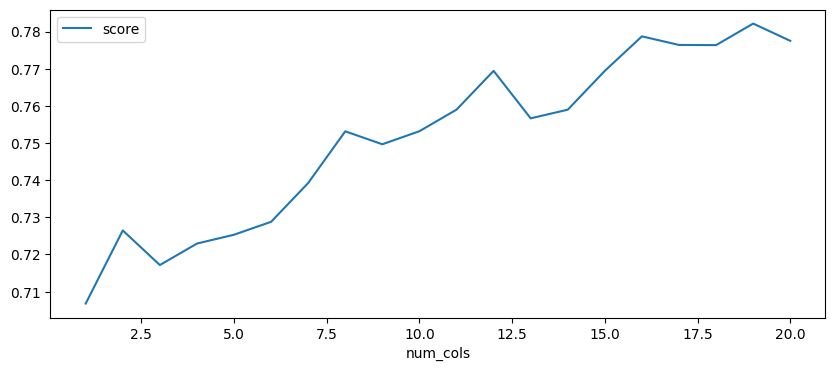

In [53]:
#Проходимся по всем фичам и смотрим, дает ли каждая из них прирост или наоборот портит
MODEL_COLUMNS = fe.head(20)['feature_names'].tolist()
d_score_res = plot_metric_by_feature(MODEL_COLUMNS, clf)

In [ ]:
#Если скор ухудшается с добавлением этой фичи - то эту фичу не добавляем
features = fe.head(20)['feature_names'].tolist()
test_metric_compare = 0
MODEL_COLUMNS = []

for feature in features:
    MODEL_COLUMNS.append(feature)
    clf_baseline1, test_metric = run_model(clf, MODEL_COLUMNS, verbosity=False, print_plot=False)
    if test_metric_compare >= test_metric:
        MODEL_COLUMNS.remove(feature)
    else:
        test_metric_compare = test_metric

d_score_res = plot_metric_by_feature(MODEL_COLUMNS, clf)

CPU times: user 4min 32s, sys: 2min 35s, total: 7min 7s
Wall time: 3min 11s


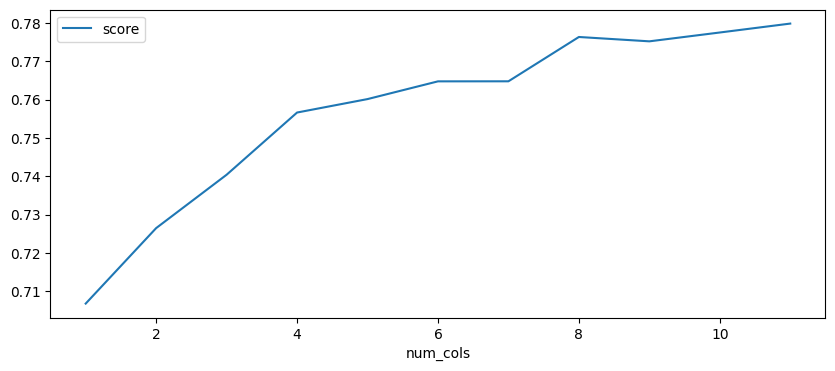

In [55]:
%%time
#из топ 20 фичей добавляем каждый раз ту, которая дает наибольший прирост по метрике
features = fe.head(20)['feature_names'].tolist()
test_metric_compare = 0

MODEL_COLUMNS = ['population_walking_5min']
for i in range(len(features)-10):
    metrics_compare = {}
    for feature in features:
        if feature not in MODEL_COLUMNS:
            MODEL_COLUMNS.append(feature)
            clf_baseline1, test_metric = run_model(clf, MODEL_COLUMNS, verbosity=False, print_plot=False)
            metrics_compare[feature] = test_metric
            MODEL_COLUMNS.remove(feature)
            
    best_feature = max(metrics_compare, key=metrics_compare.get)
    MODEL_COLUMNS.append(best_feature)
    features.remove(best_feature)

d_score_res = plot_metric_by_feature(MODEL_COLUMNS, clf)

In [56]:
pd.DataFrame(d_score_res)

,num_cols,score
0,1,0.706782
1,2,0.726469
2,3,0.740388
3,4,0.756614
4,5,0.760122
5,6,0.764747
6,7,0.764760
7,8,0.776321
8,9,0.775185
9,10,0.777490


**Выбор параметров модели**

In [57]:
len(MODEL_COLUMNS)

11

In [67]:
clf = CatBoostClassifier(
    iterations=100,
    #depth = 10,
    learning_rate=0.1, 
    loss_function='CrossEntropy',
    random_state=RANDOM_STATE,
    verbose = False
)
clf_baseline1, test_metric = run_model(clf, MODEL_COLUMNS, print_plot=True)

test_accuracy metrics: 0.9624 ± 0.0017
test_roc_auc metrics: 0.9822 ± 0.0009
test_recall metrics: 0.7775 ± 0.0154
test_precision metrics: 0.8375 ± 0.021


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [103]:
df_predicitions = df_X.reset_index()[[f'geo_h3_{RES}', 'target', 'cnt', 'desc']+MODEL_COLUMNS]
df_predicitions['predictions'] = clf_baseline1.predict_proba(df_X[MODEL_COLUMNS])[:, 1]
df_predicitions['predictions_binary'] = df_predicitions['predictions']\
                                            .apply(lambda x: 1 if x > 0.5 else 0)

In [104]:
df_predicitions['bins'] = pd.cut(df_predicitions['predictions'], 7)
df_predicitions.groupby('bins').agg({'predictions': 'mean', 'target': 'mean'})

,predictions,target
bins,,
"(0.000447, 0.143]",0.011353,0.031944
"(0.143, 0.284]",0.208744,0.453271
"(0.284, 0.426]",0.355738,0.641115
"(0.426, 0.567]",0.494870,0.741722
"(0.567, 0.709]",0.642395,0.893175
"(0.709, 0.85]",0.785589,0.935818
"(0.85, 0.992]",0.942116,0.986470


In [105]:
# предсказания на весь город
df_pred_all = df_piv.reset_index()[[f'geo_h3_{RES}']]
df_pred_all['predictions'] = clf_baseline1.predict_proba(df_piv[MODEL_COLUMNS])[:, 1]
df_pred_all['model_type'] = 'Бинарная модель с учётом проходимости'
df_pred_all['predictions'] = df_pred_all['predictions'].astype(float)

In [106]:
df_postamats['icon'] = 'place'

In [107]:
#Выбр хексагон, в которых стоят постаматы, которы плохо предсказываются
df_postamats_pred = df_postamats.merge(
    df_predicitions[['geo_h3_10', 'target', 'predictions']], on='geo_h3_10'
)
df_postamats_pred['predictions_binary'] = df_postamats_pred['predictions']\
                                            .apply(lambda x: 1 if x > 0.5 else 0)
recall_score(df_postamats_pred['target'], df_postamats_pred['predictions_binary'])

0.7718407151564405

<AxesSubplot: >

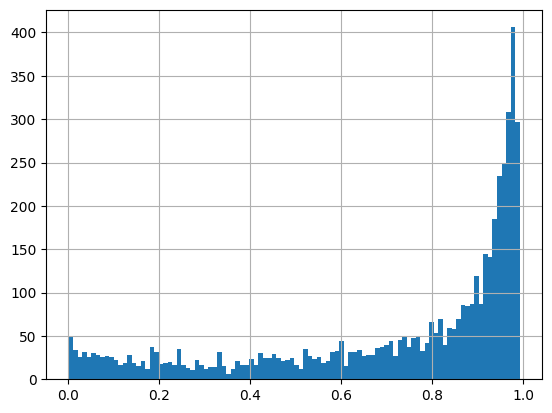

In [108]:
df_postamats_pred['predictions'].hist(bins=100)

In [109]:
#расчет скора на постаматы каждой компании в отдельности
d_score_by_company = {'company':[],'sum_target':[], 'sum_predictions':[], 
                      'cnt_target':[], 'score':[]}

for company in df_postamats['company'].drop_duplicates().tolist():
    filtered_df = df_postamats_pred[df_postamats_pred['company']==company].reset_index(drop=True).copy()
    
    #if filtered_df.shape[0]>2:
    
    d_score_by_company['sum_target'].append(filtered_df['target'].sum())
    d_score_by_company['sum_predictions'].append(filtered_df['predictions_binary'].sum())
    d_score_by_company['cnt_target'].append(filtered_df['target'].count())

    d_score_by_company['company'].append(company)
    d_score_by_company['score'].append(recall_score(filtered_df['target'], filtered_df['predictions_binary']))

df_score_by_company = pd.DataFrame(d_score_by_company).sort_values(by='score', ascending=False)
# df_score_by_company

/Users/mariastepanova/opt/anaconda3/envs/ltc22/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/Users/mariastepanova/opt/anaconda3/envs/ltc22/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/Users/mariastepanova/opt/anaconda3/envs/ltc22/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/Users/mariastepanova/opt/anaconda3/envs/ltc22/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true sample

In [78]:
df_score_by_company

,company,sum_target,sum_predictions,cnt_target,score
12,Wildberries,2,2,2,1.000000
32,Постамат,1,1,1,1.000000
29,Чайка,1,1,1,1.000000
19,Eurospar,2,2,2,1.000000
30,Smart box,1,1,1,1.000000
26,SaveTime,1,1,1,1.000000
2,СберЛогистика,315,254,315,0.806349
16,Teleport,115,92,115,0.800000
6,Яндекс. Маркет,629,502,629,0.798092
4,OmniCDEK,161,127,161,0.788820


In [110]:
bad_hex_with_postamat = df_postamats_pred[df_postamats_pred['company'].isin(
            df_score_by_company[df_score_by_company['score']<0.6]['company'].tolist())]['geo_h3_10']\
    .drop_duplicates().tolist()

In [111]:
df_postamats_pred

,rubric,name,id,address_building_id,rubrics_0_name,point_lat,point_lon,geo_h3_10,geometry,company,icon,target,predictions,predictions_binary
0,Постаматы,"Почта России, почтомат",70000001057201203,4504235282715039,Постаматы,55.730147,37.645149,8a11aa78c59ffff,0101000020E61000000806103E94D24240E222F77475DD...,Почта России,place,1,0.468695,0
1,Постаматы,"OZON box, автоматизированный пункт выдачи",70000001030825455,4504235282715039,Постаматы,55.730147,37.645149,8a11aa78c59ffff,0101000020E61000000806103E94D24240E222F77475DD...,OZON box,place,1,0.468695,0
2,Постаматы,"Cainiao, постамат",70000001059861253,4504235282715039,Постаматы,55.730147,37.645149,8a11aa78c59ffff,0101000020E61000000806103E94D24240E222F77475DD...,Cainiao,place,1,0.468695,0
3,Постаматы,ABonBox,70000001057201205,4504235282715039,Постаматы,55.730147,37.645149,8a11aa78c59ffff,0101000020E61000000806103E94D24240E222F77475DD...,ABonBox,place,1,0.468695,0
4,Постаматы,"Почта России, почтомат",70000001061605722,4504235282582956,Постаматы,55.710598,37.598272,8a11aa780b87fff,0101000020E6100000670E492D94CC42402F4D11E0F4DA...,Почта России,place,1,0.592964,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,Постаматы,"Почта России, почтомат",70000001056462781,4504235283047867,Постаматы,55.765587,37.560289,8a11aa7ac007fff,0101000020E61000007EA7C98CB7C74240129F3BC1FEE1...,Почта России,place,1,0.515831,1
4918,Постаматы,"OZON box, автоматизированный пункт выдачи",70000001030443821,4504235282749416,Постаматы,55.770355,37.596673,8a11aa7a8aaffff,0101000020E6100000FFB3E6C75FCC4240B1A71DFE9AE2...,OZON box,place,1,0.794224,1
4919,Постаматы,"Почта России, почтомат",70000001063391828,4504235282888951,Постаматы,55.713106,37.891630,8a11aa6812e7fff,0101000020E6100000F5108DEE20F242406B4AB20E47DB...,Почта России,place,1,0.980012,1
4920,Постаматы,"PickPoint, постамат",70000001064724060,4504235282752169,Постаматы,55.748294,37.583867,8a11aa7ae38ffff,0101000020E6100000581B6327BCCA424082E50819C8DF...,PickPoint,place,1,0.767868,1


In [84]:
from shapash import SmartExplainer

In [113]:
xpl = SmartExplainer(
  model=clf_baseline1,
)

In [114]:
xpl.compile(
    x=df_predicitions[MODEL_COLUMNS],    
    y_pred=df_predicitions['predictions_binary'], # Optional: for your own prediction (by default: model.predict)
    y_target=df_predicitions['target'], # Optional: allows to display True Values vs Predicted Values
)

In [115]:
app = xpl.run_app()

/Users/mariastepanova/opt/anaconda3/envs/ltc22/lib/python3.8/site-packages/shapash/webapp/smart_app.py:338: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.

INFO:root:Your Shapash application run on http://MacBook-Pro-Maria.local:8050/


Dash is running on http://0.0.0.0:8050/



INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8050/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app 'shapash.webapp.smart_app'
 * Debug mode: off


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET /assets/jquery.js?m=1667480558.00595 HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET /assets/material-icons.css?m=1667480558.0062973 HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET /assets/style.css?m=1667480558.008386 HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET /assets/main.js?m=1667480558.0061557 HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET /_dash-layout HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 16:38:06] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [03/

In [79]:
df_postamats_pred[(df_postamats_pred['company']=='Cainiao')\
                  &(df_postamats_pred['predictions_binary']!=df_postamats_pred['target'])]\
        [['geo_h3_10', 'target', 'predictions']]

,geo_h3_10,target,predictions
2,8a11aa78c59ffff,1,0.468695
46,8a11aa7aa4dffff,1,0.337248
98,8a11aa71d077fff,1,0.058592
127,8a11aa6b48e7fff,1,0.153578
138,8a1181b61d0ffff,1,0.422040
...,...,...,...
4785,8a11aa632d6ffff,1,0.191747
4800,8a11aa795927fff,1,0.308896
4801,8a11aa7a1c07fff,1,0.008081
4823,8a11aa70b90ffff,1,0.412400


In [82]:
map_ = KeplerGl(height=800)
# map_.add_data(df_pred_all, 'data')
map_.add_data(df_postamats_pred[(df_postamats_pred['company']=='Cainiao')\
                  &(df_postamats_pred['predictions_binary']!=df_postamats_pred['target'])]\
        [['point_lat', 'point_lon', 'target', 'predictions']], 'postamats')
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'postamats': {'index': [2, 46, 98, 127, 138, 145, 181, 186, 242, 303, 322, 413, 416, 430, 460, …

In [34]:
map_cfg = '../rnd_data/model_map_cfg'
cfg = gt.load_pickle(map_cfg)

In [159]:
map_ = KeplerGl(config = cfg, height=800)
# map_.add_data(df_pred_all, 'data')
map_.add_data(df_postamats, 'postamats')
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data'], 'id': 'k4pgk9xnm', …

In [29]:
gt.save_pickle(map_.config, map_cfg)

In [34]:
# df_pred_all.to_sql(schema=SCHEMA, name = 'platform_model', con=engine, if_exists='replace', index=None)

### Маска канибализации

In [42]:
df_postamats_unique = df_postamats.drop_duplicates(subset = f'geo_h3_{RES}')[['point_lat', 'point_lon']]
df_postamats_unique['join'] = 1
df_domain = gt.geo_lat_lon_from_h3(df_domain, f'geo_h3_{RES}')
df_domain_ll = df_domain[['lat', 'lon']].copy()
df_domain_ll['join'] = 1
df_mask = pd.merge(df_domain_ll, df_postamats_unique, on = 'join')

In [56]:
df_mask['dist'] = haversine_np(
    df_mask['lat'], df_mask['lon'], df_mask['point_lat'], df_mask['point_lon'])

In [58]:
df_mask = df_mask[df_mask['dist'] < 10]
df_mask[f'geo_h3_{RES}'] = gt.make_h3_index(df_mask, 'lat', 'lon', RES)

In [63]:
df_mask = df_mask.sort_values(by = [f'geo_h3_{RES}', 'dist'])
df_mask_f = df_mask.drop_duplicates(subset = f'geo_h3_{RES}')[[f'geo_h3_{RES}', 'dist']]

In [124]:
df_mask_f.to_sql(schema=SCHEMA, name = 'platform_can_mask', con=engine, if_exists='replace', index=None)

In [125]:
df_merge = pd.merge(df_pred_all, df_mask_f, on = f'geo_h3_{RES}')
df_merge['predictions'] = df_merge['predictions'] * df_merge['dist']

df_merge = df_merge.drop(['dist'], axis = 1)
df_merge['model_type'] = 'Бинарная модель с учётом конкурентов'
scaler = MinMaxScaler()
df_merge['predictions'] = scaler.fit_transform(df_merge['predictions'].values.reshape(-1,1))


In [127]:
df_merge.sort_values(by = 'predictions')

,geo_h3_10,predictions,model_type
9826,8a11aa443157fff,0.000000,Бинарная модель с учётом конкурентов
13225,8a11aa455147fff,0.000020,Бинарная модель с учётом конкурентов
65636,8a11aa799b6ffff,0.000062,Бинарная модель с учётом конкурентов
53641,8a11aa729647fff,0.000108,Бинарная модель с учётом конкурентов
56336,8a11aa735d6ffff,0.000109,Бинарная модель с учётом конкурентов
...,...,...,...
27565,8a11aa61d717fff,0.874899,Бинарная модель с учётом конкурентов
65331,8a11aa798d0ffff,0.880048,Бинарная модель с учётом конкурентов
72039,8a11aa7ae6dffff,0.880909,Бинарная модель с учётом конкурентов
70825,8a11aa7aad47fff,0.959543,Бинарная модель с учётом конкурентов


In [128]:
df_merge.to_sql(schema=SCHEMA, name = 'platform_model', con=engine, if_exists='append', index=None)

In [111]:
map_2 = create_Kepler_map()
map_2.add_data(df_merge, 'data')
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [], 'interactionConfig': {'…

#### бесполезное

In [428]:
df_comanies = pd.read_csv("../data/popular_rubrics.csv", sep = ';')

In [429]:
df_first = df_comanies[df_comanies['rubric'].isin(['МФЦ', 'Библиотеки', 'Киоски / магазины по продаже печатной продукции'])]

In [437]:
df_first

,city,rubric,name,id,address_building_id,address_name,address_components_0_street_id,point_lat,point_lon,geo_h3_10
223769,Москва,Киоски / магазины по продаже печатной продукции,Киоск по продаже печатной продукции,70000001063172855,4.504235e+15,"Чертановская улица, 23а киоск",4.504338e+15,55.619485,37.594221,8a11aa7964d7fff
223770,Москва,Киоски / магазины по продаже печатной продукции,Киоск печатной продукции,70000001051366500,4.504235e+15,"Таганская улица, 17-23 киоск",4.504338e+15,55.739881,37.664718,8a11aa7889b7fff
223771,Москва,Киоски / магазины по продаже печатной продукции,"Антарес, киоск печатной продукции",70000001056366106,4.504235e+15,"Шаболовка, 69/32 киоск",4.504338e+15,55.712127,37.607468,8a11aa780ad7fff
223772,Москва,Киоски / магазины по продаже печатной продукции,"Антарес, киоск печатной продукции",70000001035127032,4.504235e+15,"улица Ботаническая, 29 к1 киоск",4.504338e+15,55.833503,37.594910,8a11aa719d17fff
223773,Москва,Киоски / магазины по продаже печатной продукции,"Краснопресненское агентство печати, киоск печа...",70000001020380697,4.504235e+15,"улица Хачатуряна, вл15Б киоск",4.504338e+15,55.862610,37.603798,8a11aa70a3a7fff
...,...,...,...,...,...,...,...,...,...,...
286554,Москва,МФЦ,"Мои документы, центр предоставления государств...",70000001035526710,4.504235e+15,"Шама, 9",4.504338e+15,55.634398,37.849618,8a11aa690817fff
286555,Москва,МФЦ,"Мои документы, центр государственных услуг",70000001020297229,4.504235e+15,"Школьная, 5",4.504338e+15,55.661034,37.983219,8a11aa69b727fff
286556,Москва,МФЦ,"Мои документы, центр государственных услуг",70000001040612623,4.504235e+15,"деревня Брёхово, ст83м",NaN,55.929326,37.194138,8a11aa0134a7fff
286557,Москва,МФЦ,"Мои документы, Паспортный стол",70000001029074362,4.504235e+15,"Академика Жукова, 40",4.504338e+15,55.625136,37.837482,8a11aa696b5ffff


In [430]:
df_pred_all = df_piv.reset_index()[[f'geo_h3_{RES}']]
df_pred_all['predictions'] = clf_baseline1.predict_proba(df_piv[MODEL_COLUMNS])[:, 1]

In [431]:
df_pred_all['first'] = 0
df_pred_all.loc[df_pred_all['geo_h3_10'].isin(df_first['geo_h3_10']), 'first'] = 1
df_pred_all['bins'] = pd.cut(df_pred_all['predictions'], 7)

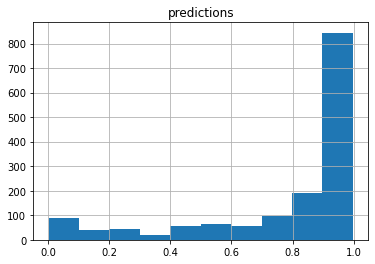

In [432]:
df_pred_all[df_pred_all['first'] == 1][['predictions']].hist();

In [433]:
df_pred_all.groupby('bins').agg({'predictions': 'mean', 'first': 'mean'})

,predictions,first
bins,,
"(-0.000412, 0.143]",0.016475,0.003312
"(0.143, 0.286]",0.208823,0.017617
"(0.286, 0.428]",0.355553,0.017309
"(0.428, 0.57]",0.501352,0.032221
"(0.57, 0.713]",0.643882,0.032168
"(0.713, 0.855]",0.792058,0.041141
"(0.855, 0.998]",0.943576,0.069464


In [393]:
map_ = create_Kepler_map()
map_.add_data(df_predicitions.drop('bins', axis = 1), 'train')
map_.add_data(df_pred_all, 'data')
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [], 'interactionConfig': {'…

### For presentation

#### Корелляция

In [241]:
corr_columns = list(MODEL_COLUMNS).copy()
corr_columns.append('postamaty_walking_10min')
corr_columns.remove('razrabotka_programmnogo_obespechenija_walking_15min')
corr_columns.remove('remont_hodovoj_chasti_avtomobilja_walking_10min')
corr_columns.remove('avtoremont_i_tehobsluzhivanie_sto_walking_5min')
corr_columns.remove('stroitelnye_materialy_walking_15min')
corr_columns.remove('stroitelnye_materialy_walking_5min')

In [242]:
corr_columns

['population_walking_5min',
 'supermarkety_walking_5min',
 'apteki_walking_5min',
 'platezhnye_terminaly_walking_5min',
 'kopirovalnye_uslugi_walking_15min',
 'population_walking_15min',
 'cnt_afternoon',
 'tsentry_rannego_razvitija_detej_walking_10min',
 'detskie_sady_walking_15min',
 'bankomaty_walking_5min',
 'hlebobulochnye_izdelija_walking_15min',
 'shkoly_walking_15min',
 'dostavka_gotovyh_bljud_walking_5min',
 'nogtevye_studii_walking_15min',
 'produktovye_magaziny_walking_5min',
 'postamaty_walking_10min']

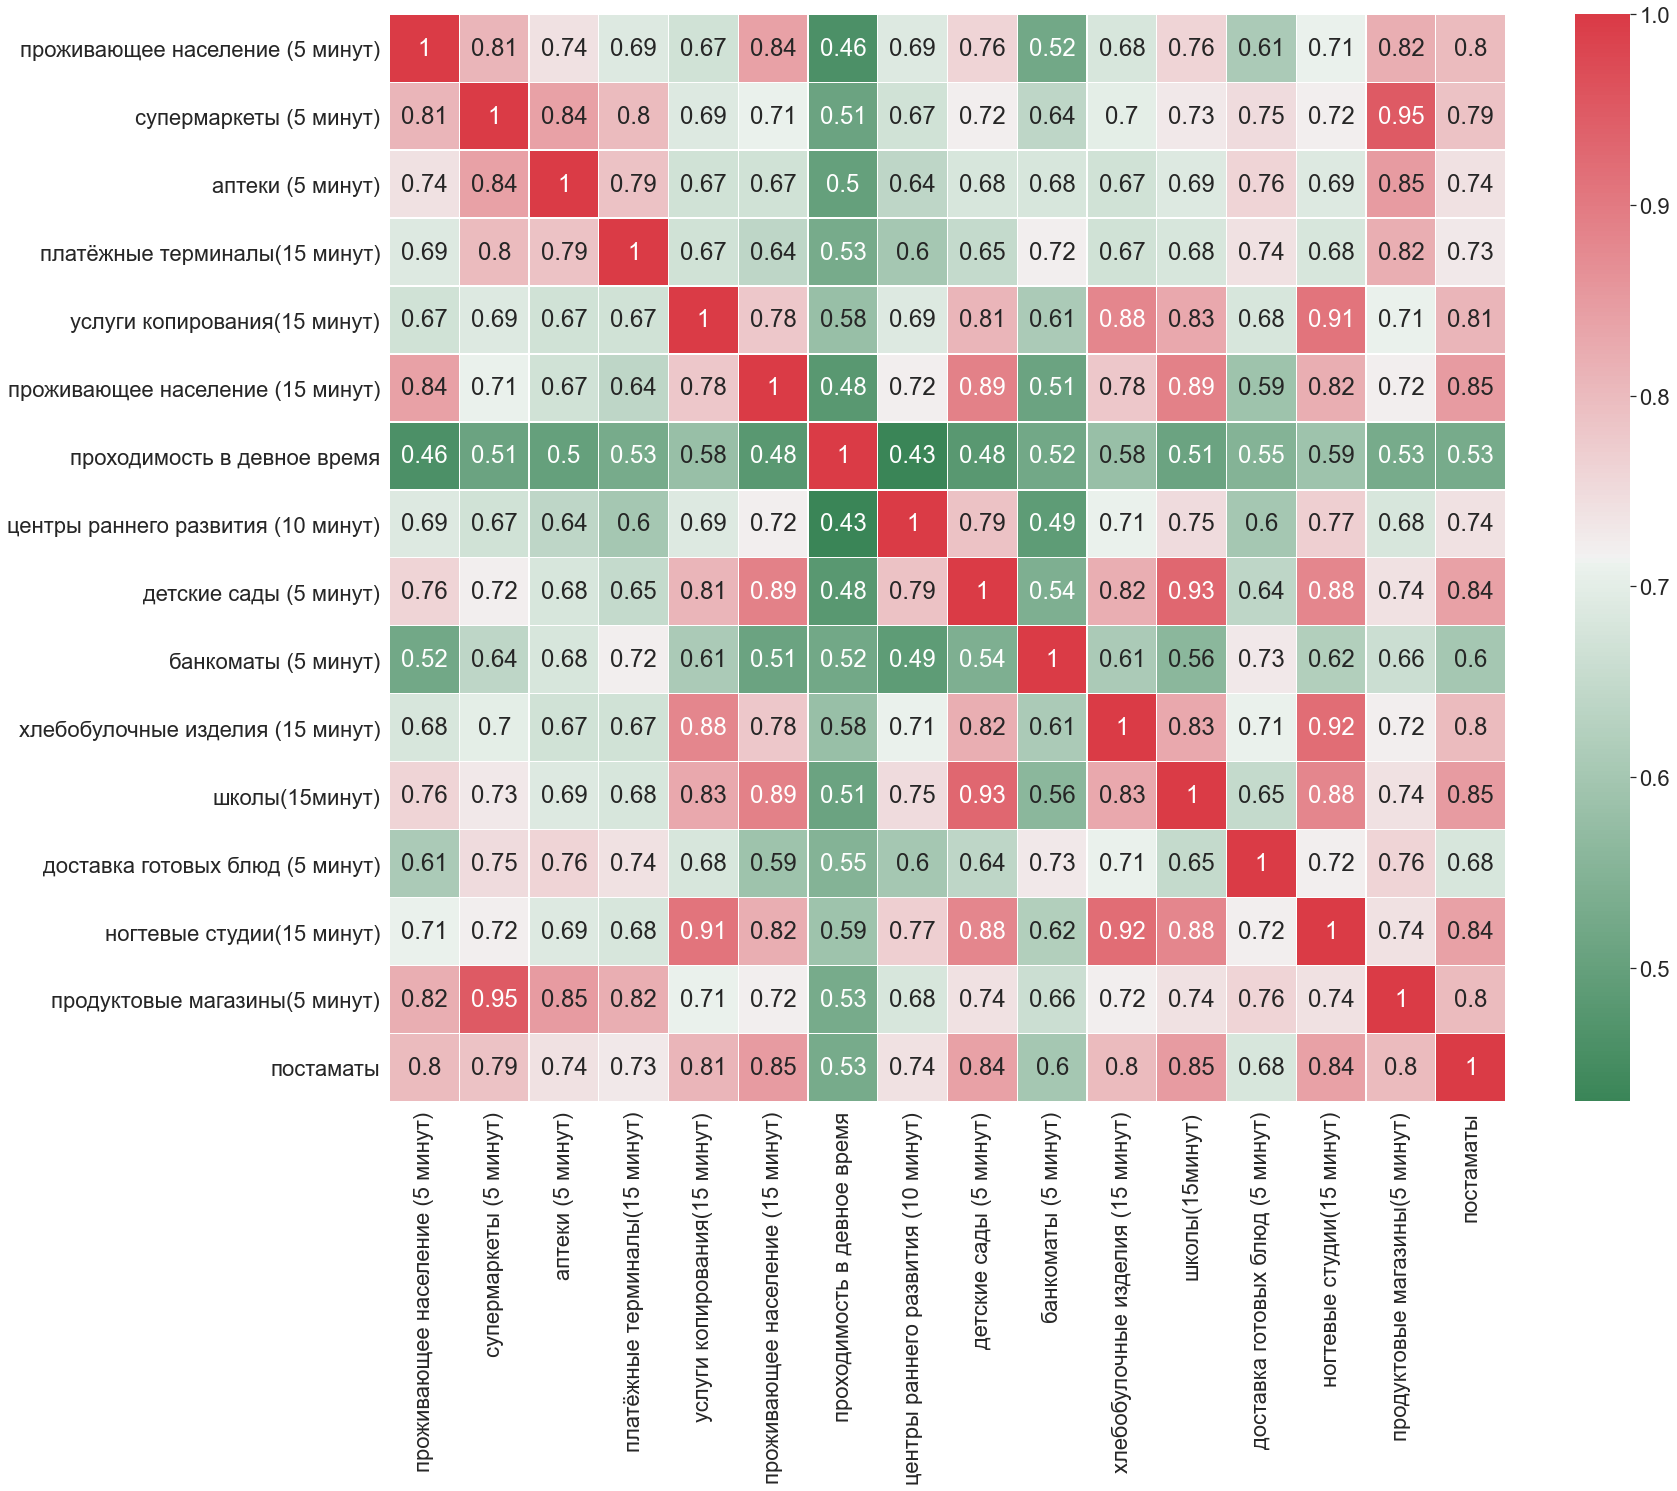

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25,20))    
# label to make it neater
labels = {
    'postamaty_walking_10min': 'постаматы',
    'population_walking_5min':'проживающее население (5 минут)',  
    'supermarkety_walking_5min':'супермаркеты (5 минут)', 
    'platezhnye_terminaly_walking_5min':'платёжные терминалы(15 минут)', 
    'kopirovalnye_uslugi_walking_15min':'услуги копирования(15 минут)', 
    'stroitelnye_materialy_walking_5min':'строительные материалы (15 минут)',
    'population_walking_15min':'проживающее население (15 минут)',
    'razrabotka_programmnogo_obespechenija_walking_15min':'разработка програмного обеспечения (15 минут)',
    'cnt_afternoon':'проходимость в девное время',
    'tsentry_rannego_razvitija_detej_walking_10min':'центры раннего развития (10 минут)',
    'remont_hodovoj_chasti_avtomobilja_walking_10min': 'ремонт ходовой части атов (10 минут)' ,   
    'detskie_sady_walking_15min':'детские сады (5 минут)',  
    'bankomaty_walking_5min':'банкоматы (5 минут)', 
    'apteki_walking_5min':'аптеки (5 минут)', 
    'hlebobulochnye_izdelija_walking_15min':'хлебобулочные изделия (15 минут)', 
    'shkoly_walking_15min':'школы(15минут)',
    'stroitelnye_materialy_walking_15min':'строительные материалы(15 минут)',
    'nogtevye_studii_walking_15min':'ногтевые студии(15 минут)',
    'avtoremont_i_tehobsluzhivanie_sto_walking_5min':'авторемонты и СТО(5 минут)',
    'produktovye_magaziny_walking_5min':'продуктовые магазины(5 минут)',
    'dostavka_gotovyh_bljud_walking_5min': 'доставка готовых блюд (5 минут)'  
}
corr = df_piv[corr_columns].corr(method='spearman')
corr = corr.rename(labels)
corr.columns = [labels[x] for x in corr.columns]
corr = corr.round(2)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if you want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
sns.set(font_scale=2)
ans=sns.heatmap(corr,  linewidths=.3, cmap=cmap, annot=True, ax=ax)
# plt.setp(ans.get_xticklabels(), rotation=45)

# #save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

### Как собираются фичи

In [250]:
from shapely import wkb

In [297]:
df_isochrones = pd.read_sql(f"""select * from {SCHEMA}.platform_isochrones
            where 1=1
                and geo_h3_10 in ('8a11aa7932affff'
                --, '8a11aa7930d7fff'
                )
                 """, engine)

df_isochrones['geometry'] = df_isochrones['geometry'].apply(lambda x: wkb.loads(x, hex=True))
gdf_shape = gpd.GeoDataFrame(df_isochrones, geometry = 'geometry')
gdf_shape = gdf_shape.h3.polyfill_resample(RES).reset_index()
df_isochrones['geometry'] = df_isochrones['geometry'].astype(str)
df_isochrones['order'] = df_isochrones['kind'].map({'walking_15min': 1, 'walking_10min': 2, 'walking_5min': 3})
df_isochrones = gt.geo_lat_lon_from_h3(df_isochrones, f'geo_h3_{RES}')
df_isochrones

,geo_h3_10,kind,geometry,order,lat,lon
0,8a11aa7932affff,walking_5min,"POLYGON ((37.658347 55.651272, 37.656898 55.65...",3,55.648108,37.658347
1,8a11aa7932affff,walking_10min,"POLYGON ((37.662347 55.652207, 37.661347 55.65...",2,55.648108,37.658347
2,8a11aa7932affff,walking_15min,"POLYGON ((37.665347 55.655493, 37.663491 55.65...",1,55.648108,37.658347


In [353]:
s = "','".join(list(gdf_shape['h3_polyfill'].unique()))
s = f"'{s}'"
df_buildings = pd.read_sql(
    f"""select * from {SCHEMA}.platform_buildings where geo_h3_{RES} in ({s})""", engine)
df_buildings['geometry'] = df_buildings['geometry'].apply(
    lambda x: wkb.loads(x, hex=True))
df_buildings['geometry'] = df_buildings['geometry'].astype(str)
df_buildings = df_buildings.drop(
    ['geometry_centroid', 'structure_info_material', 'lat', 'lon', 'id', 'name', 'address_name'], axis=1)
df_buildings['floors_ground_count'].fillna(1, inplace=True)

df_buildings['good'] = 0
df_buildings.loc[df_buildings['purpose_name'].isin(['Жилой дом', 'Киоск']), 'good'] = 1

In [354]:
df_buildings.head()

,floors_ground_count,geometry,purpose_name,structure_info_apartments_count,geo_h3_10,good
0,5.0,"POLYGON ((37.660823 55.6461, 37.661527 55.6458...",Жилой дом,60.0,8a1181b6d937fff,1
1,20.0,"POLYGON ((37.659006 55.644788, 37.659046 55.64...",Жилой дом,388.0,8a11aa793667fff,1
2,17.0,"POLYGON ((37.664333 55.641472, 37.664256 55.64...",Жилой дом,405.0,8a11aa7936cffff,1
3,5.0,"POLYGON ((37.665491 55.647606, 37.666432 55.64...",Жилой дом,70.0,8a1181b6d90ffff,1
4,5.0,"POLYGON ((37.662027 55.647375, 37.66266 55.647...",Жилой дом,55.0,8a1181b6d927fff,1


In [384]:
df_companies = pd.read_sql(
    f"""select * from {SCHEMA}.platform_companies where geo_h3_{RES} in ({s})""", engine)
df_companies['geometry'] = df_companies['geometry'].apply(
    lambda x: wkb.loads(x, hex=True))

In [378]:
good_rubrics = list(df_companies['rubric'].value_counts().head(20).index)
good_rubrics.remove('Вывоз мусора')
df_companies = df_companies[df_companies['rubric'].isin(good_rubrics)]
df_companies['geometry'] = df_companies['geometry'].astype(str)
df_companies = df_companies.drop(
    ['id', 'address_building_id', 'rubrics_0_name'], axis=1)

In [401]:
df_layer = pd.read_sql(
    f"""select * from {SCHEMA}.platform_model where geo_h3_{RES} in ({s}) """, engine)

In [402]:
df_layer_1 = df_layer[df_layer['model_type'] == 'Бинарная модель']
df_layer_2 = df_layer[df_layer['model_type'] == 'Бинарная модель с учётом конкурентов']

In [403]:
df_postamats = df_companies[df_companies['rubric'] == 'Постаматы'].copy()
df_postamats['icon'] = 'place'

In [404]:
df_buildings_opt = pd.merge(df_buildings, df_layer, on = 'geo_h3_10')
df_buildings_opt = df_buildings_opt[(
    df_buildings_opt['structure_info_apartments_count'] > 10) | (df_buildings_opt['purpose_name'] =='Киоск')]

In [405]:
df_model_layers = pd.read_sql(
    f""" select geo_h3_{RES}, population, supermarkety
    from {SCHEMA}.platform_features where geo_h3_{RES} in ({s}) and kind='walking_10min'""", engine)

In [408]:
map_pres = create_Kepler_map(config_path='map_pres_cfg')
map_pres.add_data(df_isochrones.sort_values(by = 'order'), 'isochrones')
map_pres.add_data(df_buildings, 'buildings')
map_pres.add_data(df_buildings_opt, 'buildings_opt')
map_pres.add_data(df_model_layers, 'model_features')
map_pres.add_data(df_companies.drop('geometry', axis = 1), 'companies')
map_pres.add_data(df_postamats.drop('geometry', axis = 1), 'postamats')
map_pres.add_data(df_layer_1, 'model1')
map_pres.add_data(df_layer_2, 'model2')
map_pres

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['buildings_opt'], 'id': 'z4h…

In [411]:
gt.save_pickle(map_pres.config, 'map_pres_cfg')

In [412]:
map_pres.save_to_html(data={'buildings': df_buildings, "isochrones": df_isochrones, 'model_features': df_model_layers,
                            "buildings_opt": df_buildings_opt, 'companies': df_companies.drop('geometry', axis = 1),
                            'postamats': df_postamats.drop('geometry', axis = 1), 'model1': df_layer_1, 'model2': df_layer_2}, 
                      config=map_pres.config)

Map saved to keplergl_map.html!
